In [1]:
from keras.layers import Conv2D, Dense, merge,Lambda,Input, MaxPooling2D,Lambda,Flatten
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

%matplotlib inline

Using TensorFlow backend.


In [2]:
def w_init(shape,name=None):
    values = np.random.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def b_init(shape,name=None):
    values = np.random.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [3]:
input_shape = (105,105,1)
upper_ip = Input(input_shape)
lower_ip = Input(input_shape)

model = Sequential()
model.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                kernel_initializer = w_init,kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=w_init,bias_initializer=b_init))
model.add(MaxPooling2D())
model.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=w_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
model.add(MaxPooling2D())
model.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=w_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
model.add(Flatten())
model.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=w_init,bias_initializer=b_init))

encoded_up = model(upper_ip)
encoded_down = model(lower_ip)

#Calculate L1 distance between the two flattened layers
merge = Lambda(lambda layers:K.abs(layers[0]-layers[1]))
merge_distance = merge([encoded_up,encoded_down])

prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(merge_distance)
siamese = Model(inputs=[upper_ip,lower_ip],outputs=prediction)

learning_rate = 1e-5
optimizer = Adam(learning_rate)

siamese.compile(loss='binary_crossentropy',optimizer = optimizer)

In [4]:
siamese.count_params()

38951745

In [5]:
path = "./"
with open(os.path.join(path,"train.pickle"),'rb') as f:
    (x,c) = pickle.load(f)

with open(os.path.join(path,"val.pickle"),"rb") as f:
    (xval,cval) = pickle.load(f)
    
print("Background",c.keys())
print("Evaluation",cval.keys())

Background dict_keys(['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh'])
Evaluation dict_keys(['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG'])


In [6]:
class Siamese_Net:
    #Load batches and testing tasks to a siamese network
    def __init__(self,path,data_subsets=['train','val']):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path,name+".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (x,c) = pickle.load(f)
                self.data[name]=x
                self.categories[name]=c
                
    def get_batch(self,batch_size,s="train"):
        #create batch of n pais, half same class, half different class to train network
        x = self.data[s]
        n_classes,n_examples,w,h = x.shape
        
        #randomly sample several classes to use in the batch
        categories = np.random.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for ip image batch
        pairs = [np.zeros((batch_size, h, w, 1)) for i in range(2)]
        #init vector for targets and make 1 half of it '1's, so 2nd half of batch has same class
        targets = np.zeros((batch_size,))
        targets[batch_size//2:]=1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = np.random.randint(0,n_examples)
            pairs[0][i,:,:,:] = x[category,idx_1].reshape(w,h,1)
            idx_2 = np.random.randint(0,n_examples)
            
            #choose same class images for 1st half, different for 2nd half
            if i>=batch_size//2:
                category_2 = category
            else:
                #add a random no. to the category modulo n classes to ensure different category
                category_2 = (category+np.random.randint(1,n_classes))%n_classes
            pairs[1][i,:,:,:] = x[category_2,idx_2].reshape(w,h,1)
        return pairs,targets
    
    def generate(self,batch_size, s='train'):
        while True:
            pairs,targets = self.get_batch(batch_size,s)
            yield (pairs,targets)
    
    def make_oneshot_task(self,N,s='val',language=None):
        X = self.data[s]
        n_classes,n_examples,w,h = X.shape
        indices = np.random.randint(0,n_examples,size=(N,))
        if language is not None:
            low,high = self.categories[s][language]
            if N>high-low:
                raise ValueError("This language ({}) has less than {} letters").format(language,N)
            categories = np.random.choice(range(low,high),size=(N,),replace=False)
            
        else:# if no language specified, pick a bunch of random letters
            categories = np.random.choice(range(n_classes),size=(N,),replace=False)
        true_category = categories[0]
        
        ex1,ex2 = np.random.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N,w,h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N,w,h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets,test_image,support_set = shuffle(targets,test_image,support_set)
        pairs = [test_image,support_set]
        
        return pairs,targets
   
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            ips, tgts = self.make_oneshot_task(N,s)
            probs = model.predict(ips)
            if np.argmax(probs) == np.argmax(tgts):
                n_correct+=1
        accuracy = (100.0*n_correct/k)
        if verbose:
            print("Got an avg of {}% {} way one-shot learning accuracy".format(accuracy,N))
        return accuracy
    
    def train(self,model,epochs,verbosity):
        model.fit_generator(self.generate(batch_size))
        
loader = Siamese_Net(path)

loading data from ./train.pickle
loading data from ./val.pickle


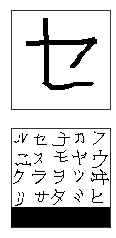

In [7]:
def concat_images(X):
    #concat a bunch of images in a matrix to plot
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x=0
    y=0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y+=1
        if y >= n:
            y = 0
            x+=1
    return img

def plot_oneshot_task(pairs):
    # Take a one-shot task given to a siamese net 
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
pairs,targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)

In [8]:
#Training loop
eval_every = 10 # interval for evaluating one-shot tasks
loss_every = 50 # no of epochs to print loss
batch_size = 256 
epochs = 90000
N_way = 20 # classes for testing one-shot tasks
n_val = 250 # no of one-shot tasks to validate on
best = -1
weights_path = os.path.join(path,"weights")
print("training")
for i in range(1,epochs):
    (ips,tgts) = loader.get_batch(batch_size)
    loss = siamese.train_on_batch(ips,tgts)
    print(loss)
    if i%eval_every == 0:
        print("evaluating")
        val_acc = loader.test_oneshot(siamese,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving model")
            siamese.save(weights_path)
            best = val_acc
    if i%loss_every == 0:
        print("Epoch {}, training loss: {:.2f},".format(i,loss))

training
4.5118876
4.5000634
4.4865727
4.4735665
4.4658957
4.458359
4.444785
4.4432087
4.438207
4.428778
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 36.4% 20 way one-shot learning accuracy
saving model
4.4296756
4.42402
4.409762
4.4183903
4.407621
4.3991804
4.404523
4.3810167
4.37246
4.3835735
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 37.2% 20 way one-shot learning accuracy
saving model
4.362816
4.372645
4.351767
4.3586774
4.3523703
4.346108
4.338603
4.3109655
4.2993746
4.3078003
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 32.0% 20 way one-shot learning accuracy
4.3111634
4.314444
4.302558
4.281323
4.279399
4.2520976
4.240328
4.271433
4.2420425
4.251316
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 29.2% 20 way one-shot learning accuracy
4.2666636
4.2239795
4.2240195
4.224096
4.2223525
4.2172165
4.197

Got an avg of 39.6% 20 way one-shot learning accuracy
Epoch 350, training loss: 3.26,
3.2649367
3.2391906
3.2178056
3.2653768
3.273306
3.2762098
3.2233906
3.2387156
3.266494
3.2041342
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 40.8% 20 way one-shot learning accuracy
3.2868028
3.2381475
3.220497
3.19969
3.2600684
3.215859
3.188367
3.2531447
3.2568457
3.2539103
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 44.0% 20 way one-shot learning accuracy
3.182316
3.1385767
3.1838298
3.2208385
3.2461123
3.1822853
3.2373548
3.1960986
3.2070992
3.2294247
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 44.0% 20 way one-shot learning accuracy
3.1761777
3.189478
3.2443104
3.1711535
3.1776748
3.1886427
3.1858778
3.168983
3.1939278
3.1887455
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 44.4% 20 way one-shot learning accuracy


Got an avg of 56.8% 20 way one-shot learning accuracy
Epoch 700, training loss: 2.73,
2.7202525
2.6636102
2.6484141
2.6917846
2.6695871
2.7040265
2.654453
2.6811757
2.7336593
2.687122
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 53.2% 20 way one-shot learning accuracy
2.680743
2.67608
2.6783087
2.673775
2.6779656
2.6490395
2.6497786
2.624557
2.6282954
2.6508193
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 50.8% 20 way one-shot learning accuracy
2.6219869
2.6769454
2.6728606
2.6682765
2.6750705
2.6099143
2.6175902
2.6643138
2.6610847
2.635531
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 53.2% 20 way one-shot learning accuracy
2.6385672
2.6545017
2.6337216
2.6282213
2.6268718
2.6067557
2.6429343
2.637597
2.6596048
2.6314435
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 57.2% 20 way one-shot learning accuracy

Got an avg of 65.2% 20 way one-shot learning accuracy
Epoch 1050, training loss: 2.29,
2.3090792
2.3114607
2.2814898
2.3171496
2.3231318
2.3133612
2.3447797
2.2959428
2.2882037
2.2792454
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 63.2% 20 way one-shot learning accuracy
2.2812517
2.305479
2.31234
2.2921147
2.3414264
2.3143852
2.2718363
2.284705
2.265357
2.2568138
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 58.8% 20 way one-shot learning accuracy
2.27897
2.3062525
2.3299303
2.3231437
2.2764754
2.2937114
2.3263705
2.2822652
2.3049562
2.2815056
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 63.6% 20 way one-shot learning accuracy
2.3028715
2.2935607
2.2653928
2.336291
2.3004327
2.2968452
2.2555823
2.2560456
2.2560697
2.2925224
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 63.6% 20 way one-shot learning accura

Got an avg of 67.6% 20 way one-shot learning accuracy
Epoch 1400, training loss: 2.06,
2.033177
2.0087662
2.0528462
2.0854704
2.0763252
2.0689926
2.0647511
2.0306284
2.0297654
2.017194
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 68.0% 20 way one-shot learning accuracy
2.0450046
2.08553
2.038156
2.0450444
2.0887635
1.9902802
2.0230777
2.0751832
1.998704
2.011816
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 63.6% 20 way one-shot learning accuracy
2.0454264
2.0282145
2.0072427
2.00107
2.01624
2.0184896
2.0290577
2.0017905
2.0352378
2.0124347
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 63.2% 20 way one-shot learning accuracy
2.1146939
2.0984364
2.077082
2.077712
2.0293465
2.01003
2.0358021
1.9823322
2.0222929
2.0220683
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 71.2% 20 way one-shot learning accuracy
2.05

1.8765959
1.9041705
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 73.2% 20 way one-shot learning accuracy
Epoch 1750, training loss: 1.90,
1.8635032
1.8575633
1.8731768
1.8587484
1.9012504
1.8658231
1.8191651
1.8410364
1.9167718
1.8588696
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 73.6% 20 way one-shot learning accuracy
1.8645607
1.8344624
1.8710436
1.8418491
1.8450989
1.8453164
1.8755242
1.849522
1.8884658
1.8598006
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 66.4% 20 way one-shot learning accuracy
1.8524541
1.9145547
1.823171
1.8338246
1.8974987
1.8805056
1.8598901
1.8531983
1.8264682
1.8369758
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 74.0% 20 way one-shot learning accuracy
1.8350104
1.8757641
1.840435
1.8658901
1.8488667
1.8389614
1.8541074
1.8598846
1.8091773
1.8670099
evaluating
Evaluating mode

1.7219615
1.7106801
1.7160275
1.6915553
1.7190577
1.7008623
1.7323273
1.6860079
1.7036316
1.709438
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 75.2% 20 way one-shot learning accuracy
Epoch 2100, training loss: 1.71,
1.7047266
1.6886214
1.7062004
1.6727629
1.7188858
1.7329957
1.6729215
1.6953359
1.7161188
1.6829985
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 70.8% 20 way one-shot learning accuracy
1.6778972
1.7122531
1.6459928
1.6794127
1.7231503
1.7059443
1.6912864
1.7165905
1.7107383
1.7013261
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 73.2% 20 way one-shot learning accuracy
1.6870928
1.6710767
1.7258582
1.7184088
1.6874529
1.6736541
1.7041262
1.689301
1.6702129
1.71938
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 72.0% 20 way one-shot learning accuracy
1.7004018
1.7019687
1.6885449
1.7298568
1.67159

Got an avg of 70.4% 20 way one-shot learning accuracy
1.6046203
1.5772016
1.5807278
1.6198986
1.6389418
1.619752
1.5720444
1.591427
1.592279
1.5865275
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 72.4% 20 way one-shot learning accuracy
Epoch 2450, training loss: 1.59,
1.6256877
1.5905509
1.6182057
1.6023123
1.5843048
1.6224058
1.5672319
1.5715714
1.5663385
1.5708343
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 76.0% 20 way one-shot learning accuracy
1.5482378
1.5680405
1.5586944
1.5456263
1.5662117
1.5702477
1.5794666
1.5460508
1.5883896
1.5609488
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 76.0% 20 way one-shot learning accuracy
1.5568453
1.5912758
1.5741191
1.5946058
1.5757377
1.5525483
1.553453
1.5338137
1.52522
1.5536236
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 77.6% 20 way one-shot learning accu

1.4594343
1.5107068
1.4674569
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.4% 20 way one-shot learning accuracy
1.4399868
1.4742959
1.4474471
1.498032
1.4573172
1.4770185
1.521177
1.469294
1.4492877
1.5309048
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 77.6% 20 way one-shot learning accuracy
Epoch 2800, training loss: 1.53,
1.4943486
1.4576666
1.4746587
1.4618524
1.460805
1.4453207
1.4623693
1.4532595
1.4716996
1.4879899
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 72.8% 20 way one-shot learning accuracy
1.4616426
1.4723626
1.4288428
1.459383
1.4535913
1.4730543
1.4593502
1.4711639
1.4647278
1.4783921
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 76.0% 20 way one-shot learning accuracy
1.4799583
1.4672424
1.453813
1.4751847
1.472169
1.4468352
1.4847414
1.464485
1.4805605
1.4569703
evaluating
Evaluating

1.3878844
1.3946166
1.380312
1.3681116
1.393386
1.4054073
1.3818966
1.3547798
1.3777584
1.3687679
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 73.6% 20 way one-shot learning accuracy
1.4115678
1.4160502
1.3861411
1.3758608
1.3921618
1.417445
1.3882908
1.3717744
1.3535129
1.4113266
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 71.6% 20 way one-shot learning accuracy
Epoch 3150, training loss: 1.41,
1.3694069
1.3895323
1.3767174
1.3875879
1.3566546
1.3511469
1.387729
1.3608141
1.3658984
1.3906851
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 71.6% 20 way one-shot learning accuracy
1.3759241
1.3532296
1.390287
1.4117949
1.3770808
1.3693558
1.3815422
1.3514733
1.3802052
1.3738
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 76.8% 20 way one-shot learning accuracy
1.3855705
1.3729495
1.4152575
1.4032567
1.3891281
1

Got an avg of 74.8% 20 way one-shot learning accuracy
1.3075264
1.3322982
1.27618
1.3231008
1.3009615
1.3192651
1.3243825
1.2869369
1.2929868
1.2980003
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.0% 20 way one-shot learning accuracy
1.2698838
1.3285475
1.3021773
1.3031275
1.3170183
1.3186266
1.3015645
1.2833695
1.3200828
1.2967083
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 78.0% 20 way one-shot learning accuracy
Epoch 3500, training loss: 1.30,
1.274543
1.280684
1.2611852
1.2646351
1.2994373
1.28316
1.2934753
1.2610298
1.2861453
1.2767254
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 77.6% 20 way one-shot learning accuracy
1.2786468
1.2736568
1.2975315
1.313361
1.335265
1.3370945
1.3033308
1.2640635
1.2737082
1.2677329
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 81.6% 20 way one-shot learning accura

Got an avg of 82.0% 20 way one-shot learning accuracy
1.2303369
1.2234155
1.2247683
1.2045344
1.2392848
1.2103093
1.228604
1.2066605
1.2620381
1.2306312
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.4% 20 way one-shot learning accuracy
1.2461016
1.2108538
1.1730171
1.1946113
1.2326553
1.2115723
1.2397263
1.2262332
1.2137706
1.2127502
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 77.6% 20 way one-shot learning accuracy
Epoch 3850, training loss: 1.21,
1.2229877
1.200682
1.2049702
1.2636616
1.1970431
1.2179803
1.2326694
1.2404755
1.2003813
1.2323122
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.0% 20 way one-shot learning accuracy
saving model
1.1959568
1.2060994
1.1804559
1.2242256
1.191363
1.2264466
1.2024411
1.1907681
1.2049443
1.2253762
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 78.0% 20 way one-sh

1.1654781
1.1399888
1.1424608
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 78.8% 20 way one-shot learning accuracy
1.1733973
1.1522565
1.1488731
1.1793549
1.1599319
1.1396586
1.1327252
1.1747806
1.1378866
1.1332016
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.0% 20 way one-shot learning accuracy
1.1496127
1.1507258
1.145243
1.1681068
1.1267408
1.1435721
1.1095666
1.1559513
1.1471262
1.1516347
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.8% 20 way one-shot learning accuracy
Epoch 4200, training loss: 1.15,
1.1634312
1.1758715
1.1615434
1.137255
1.1649117
1.1246047
1.1298122
1.161839
1.1690594
1.1392657
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.2% 20 way one-shot learning accuracy
1.136083
1.122234
1.1535023
1.1120821
1.1408222
1.1541533
1.1494784
1.1640844
1.1876464
1.1144624
evaluating
Evaluat

1.0635457
1.1217031
1.0999173
1.0760332
1.0842208
1.110204
1.084193
1.0947385
1.0847456
1.0529497
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 79.2% 20 way one-shot learning accuracy
1.0868585
1.088938
1.0632553
1.0823512
1.0811983
1.0612626
1.0749968
1.108052
1.1025686
1.09795
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.0% 20 way one-shot learning accuracy
1.0600054
1.0683211
1.0883682
1.0997943
1.0499278
1.0829036
1.0975715
1.0781332
1.1347967
1.0874412
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 77.6% 20 way one-shot learning accuracy
Epoch 4550, training loss: 1.09,
1.0764625
1.0717762
1.0640359
1.1120087
1.0594535
1.093158
1.0732462
1.1207834
1.0707036
1.0881844
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.4% 20 way one-shot learning accuracy
1.0696521
1.0988038
1.0886207
1.0667121
1.0826107


Got an avg of 80.4% 20 way one-shot learning accuracy
1.0236942
1.0255595
1.0488402
1.0116696
0.99808383
1.0110266
0.9921608
1.0277877
1.025425
1.0012484
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 78.8% 20 way one-shot learning accuracy
1.0194191
1.0411876
1.0188425
1.0277175
1.0282567
1.0266142
1.0365295
1.0101465
1.0196258
1.0240542
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.4% 20 way one-shot learning accuracy
1.0245514
1.0229292
1.0441667
1.0120565
1.0502316
1.0106529
1.0184189
1.0067036
1.0036181
0.99159116
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 79.2% 20 way one-shot learning accuracy
Epoch 4900, training loss: 0.99,
1.0297856
1.0205755
1.0192777
0.9840078
1.016092
1.0181942
1.0117836
1.0170501
1.0096313
1.0140276
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.8% 20 way one-shot learnin

0.9545335
0.95956403
0.9631091
0.98134494
0.98962826
1.0238574
0.96425116
0.96757007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.8% 20 way one-shot learning accuracy
0.93854964
0.9788467
0.9796815
0.96409553
0.98026633
1.0060564
0.9556596
0.9772472
0.9640304
0.9607109
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 81.6% 20 way one-shot learning accuracy
0.9694637
0.9478477
0.999697
0.9695376
1.0038843
0.9570482
0.9569856
0.95085114
0.98141545
0.96571684
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.6% 20 way one-shot learning accuracy
0.98468286
0.9618644
0.9965942
0.9821165
0.9882443
0.95281446
0.96838063
0.95406586
0.95739657
0.9582893
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.4% 20 way one-shot learning accuracy
Epoch 5250, training loss: 0.96,
1.0018313
0.94594693
0.9729713
0.9398268
0.95773

0.92021793
0.9280033
0.88968605
0.91813767
0.9251429
0.913585
0.93749636
0.9324508
0.9409657
0.9265963
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.4% 20 way one-shot learning accuracy
0.9273667
0.9092232
0.95795345
0.9284549
0.93582726
0.9231568
0.9040473
0.9201641
0.9295655
0.93634695
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
0.9160269
0.9411515
0.9039302
0.9177555
0.9164033
0.91570574
0.932938
0.91748273
0.9008873
0.9034559
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.8% 20 way one-shot learning accuracy
0.9256655
0.91822237
0.88382924
0.93982464
0.9268842
0.9714016
0.91651183
0.9046469
0.9048701
0.93081814
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.0% 20 way one-shot learning accuracy
0.9073841
0.9419717
0.92605275
0.9239865
0.91817594
0.92738575
0

0.8521449
0.8671306
0.85868484
0.91821086
0.85421187
0.8821216
0.88301355
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.6% 20 way one-shot learning accuracy
Epoch 5900, training loss: 0.88,
0.8589794
0.8641194
0.87571406
0.899473
0.87514913
0.9308031
0.8925261
0.8939505
0.8907954
0.8856914
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.8% 20 way one-shot learning accuracy
0.88934565
0.87008715
0.87665397
0.8826281
0.88815695
0.85858184
0.8922404
0.88137966
0.87895113
0.86283493
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.0% 20 way one-shot learning accuracy
0.86943537
0.8738261
0.86853594
0.8618157
0.8525282
0.864283
0.8620894
0.86413866
0.8647373
0.86321986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.2% 20 way one-shot learning accuracy
0.879574
0.8589061
0.85923994
0.86146724
0.8604283
0.8636

0.8211733
0.8657656
0.8795691
0.86759543
0.8376093
0.81857914
0.8638574
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.4% 20 way one-shot learning accuracy
0.82873476
0.82340133
0.8470598
0.8384073
0.84554917
0.8223685
0.8279018
0.84440136
0.8024311
0.83057594
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 77.2% 20 way one-shot learning accuracy
Epoch 6250, training loss: 0.83,
0.8405172
0.83383083
0.8317641
0.827939
0.8172285
0.83098054
0.82099116
0.8279888
0.8322246
0.8419655
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 76.8% 20 way one-shot learning accuracy
0.8316623
0.84337586
0.82565844
0.8130512
0.8441928
0.82955414
0.85651153
0.83215743
0.8306564
0.8103048
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.0% 20 way one-shot learning accuracy
0.8146537
0.8258769
0.8090903
0.84050703
0.82781184
0.83021

0.7922908
0.7852871
0.78906447
0.7964548
0.79910237
0.7804254
0.82715964
0.80144715
0.7861693
0.8169202
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.6% 20 way one-shot learning accuracy
0.79748
0.77478236
0.7960704
0.7786529
0.8036278
0.78817916
0.790422
0.7824558
0.78752565
0.8117673
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
0.79385483
0.8224925
0.7888828
0.80325806
0.78015876
0.7947172
0.81621355
0.7798175
0.80430174
0.7728395
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.4% 20 way one-shot learning accuracy
Epoch 6600, training loss: 0.77,
0.8080993
0.77909905
0.7788934
0.78516567
0.7864745
0.8011216
0.82245505
0.7683045
0.7830318
0.79599607
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.0% 20 way one-shot learning accuracy
0.7916344
0.81315637
0.7985719

0.75801015
0.7440102
0.7563167
0.7637233
0.7782612
0.73814636
0.73666745
0.73818123
0.73499644
0.7762955
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.2% 20 way one-shot learning accuracy
0.7464676
0.75157225
0.76319396
0.73684067
0.7499575
0.7442003
0.73909026
0.77960765
0.75644755
0.736488
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 81.2% 20 way one-shot learning accuracy
0.75704604
0.7424063
0.74728125
0.7511244
0.74543715
0.7323112
0.7506101
0.742993
0.7546955
0.7672316
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.8% 20 way one-shot learning accuracy
0.76557624
0.77058953
0.7423224
0.762428
0.7383952
0.74081355
0.7633245
0.7713837
0.749275
0.7628521
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 76.8% 20 way one-shot learning accuracy
Epoch 6950, training loss: 0.76,
0.77075356
0.73606366
0.744508

0.7268488
0.7357248
0.7675898
0.7066383
0.72860605
0.7141212
0.72202325
0.72485554
0.73038566
0.77541256
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 78.8% 20 way one-shot learning accuracy
0.70991653
0.7503039
0.717693
0.7163433
0.7053829
0.71663636
0.7237257
0.7315499
0.7307368
0.72425294
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.0% 20 way one-shot learning accuracy
0.74470496
0.70735353
0.7183822
0.70957685
0.70666844
0.7121189
0.7313076
0.7221375
0.7052592
0.71693337
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.0% 20 way one-shot learning accuracy
0.7320743
0.7060341
0.6961431
0.7112889
0.7127081
0.73819363
0.7042466
0.7061973
0.71171373
0.72999173
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.8% 20 way one-shot learning accuracy
0.7154328
0.7004347
0.72608924
0.7036141
0.7086109
0.7328669


0.6926334
0.68989277
0.675998
0.67964196
0.67255974
0.67979336
0.6929785
0.69372773
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.0% 20 way one-shot learning accuracy
Epoch 7600, training loss: 0.69,
0.6901402
0.68743896
0.6880687
0.68530566
0.6947947
0.6789546
0.6854074
0.6974866
0.69745034
0.7406352
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 79.2% 20 way one-shot learning accuracy
0.68463606
0.698924
0.6888877
0.6972664
0.66769105
0.7061978
0.7024616
0.681497
0.6855857
0.68460804
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
0.6877093
0.69735634
0.69005793
0.66363513
0.6989845
0.6744316
0.6750576
0.6827349
0.707566
0.68153936
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.2% 20 way one-shot learning accuracy
0.6830352
0.7097348
0.66977936
0.67439085
0.6710136


0.68793416
0.6467456
0.64348954
0.65088075
0.64214927
0.6588029
0.63992786
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.66178274
0.67880964
0.64576614
0.6865115
0.6646481
0.650508
0.6640132
0.69616276
0.6697099
0.6585622
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
Epoch 7950, training loss: 0.66,
0.64311767
0.6444446
0.6633869
0.65612674
0.6452226
0.6410236
0.6432957
0.66104716
0.66148823
0.65354794
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
0.66476595
0.647874
0.6622787
0.6781894
0.6372545
0.6364899
0.65838075
0.6662527
0.66683173
0.6380879
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.6% 20 way one-shot learning accuracy
0.663367
0.64709824
0.6842787
0.64840925
0.6570841
0.65274

0.63425285
0.61668146
0.6368764
0.60919774
0.6427325
0.6351495
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
0.63235104
0.6136262
0.63998365
0.6216752
0.6286975
0.63568264
0.62247586
0.6207035
0.62479407
0.63175875
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.4% 20 way one-shot learning accuracy
0.60824
0.631557
0.626862
0.6169249
0.61675984
0.63764787
0.6103775
0.6217054
0.598877
0.6213026
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
Epoch 8300, training loss: 0.62,
0.66365016
0.6243687
0.6078113
0.6116742
0.6101954
0.6270233
0.64285064
0.62209255
0.6357577
0.62004256
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.4% 20 way one-shot learning accuracy
0.61194736
0.64422363
0.6072392
0.61471486
0.6072
0.6263393
0.6480452
0.6

0.61921674
0.59359074
0.5945732
0.6097677
0.6180017
0.61984473
0.60681266
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
0.6217628
0.609227
0.60070145
0.5831861
0.5958294
0.602823
0.6447916
0.5874066
0.6017188
0.60918856
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.2% 20 way one-shot learning accuracy
0.6261478
0.608598
0.62230974
0.5988072
0.6046739
0.58978415
0.5864366
0.5989405
0.5891776
0.58775824
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 81.6% 20 way one-shot learning accuracy
0.5974198
0.61806333
0.58369994
0.5877869
0.5819754
0.5932496
0.59667236
0.6062899
0.6312252
0.60461724
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
Epoch 8650, training loss: 0.60,
0.5743839
0.5939849
0.6013395
0.6229787
0.6030023
0.5813492
0.5

0.5857538
0.5768961
0.5613017
0.58356416
0.5683106
0.57430893
0.6065404
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.551953
0.5842851
0.5853432
0.56123304
0.58560777
0.5651115
0.57179874
0.60360557
0.5612065
0.56467783
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.8% 20 way one-shot learning accuracy
0.58969665
0.57905394
0.55777675
0.55972314
0.5907602
0.56153464
0.5670531
0.5613026
0.55298096
0.5660159
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.6% 20 way one-shot learning accuracy
0.5558984
0.5796903
0.58985853
0.5672368
0.55429053
0.5760814
0.56038564
0.58322185
0.57594264
0.581843
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.6% 20 way one-shot learning accuracy
0.57765144
0.5518446
0.5645596
0.5797409
0.61422867
0.5993338
0.55766207
0.5832381
0.57043

0.552851
0.5446
0.54225403
0.54088986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 77.6% 20 way one-shot learning accuracy
Epoch 9300, training loss: 0.54,
0.5474371
0.5332472
0.55368173
0.54641086
0.53462386
0.5385656
0.56644094
0.5389965
0.5304836
0.53849435
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.0% 20 way one-shot learning accuracy
0.52928054
0.5550516
0.5474228
0.55025023
0.5678418
0.54153967
0.54838645
0.5476014
0.5559445
0.56674063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.6% 20 way one-shot learning accuracy
0.52373785
0.5264883
0.5504263
0.54013216
0.55836695
0.5689777
0.55324787
0.54757327
0.5506294
0.5419695
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.53775305
0.5292844
0.5368764
0.53427106
0.552274
0.5390391
0.59906715
0.5545618
0.541429

0.51483643
0.523164
0.50453734
0.5217739
0.5325517
0.51205206
0.5219462
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.8% 20 way one-shot learning accuracy
0.5303895
0.5170913
0.5100149
0.54589844
0.5207606
0.5477577
0.51214063
0.52110356
0.5230788
0.5176608
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.0% 20 way one-shot learning accuracy
Epoch 9650, training loss: 0.52,
0.52959627
0.5224681
0.5280969
0.51971203
0.51937306
0.51513934
0.51741195
0.5273338
0.53341395
0.5131526
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.4% 20 way one-shot learning accuracy
0.5081776
0.50603044
0.5131576
0.5086961
0.5255679
0.5581607
0.51737946
0.5245882
0.5327989
0.53583294
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
0.54923546
0.5281906
0.51114404
0.5141973
0.5160759
0.5287


0.5008688
0.50431675
0.5068803
0.5109254
0.5169011
0.5118193
0.5036624
0.49432915
0.50337654
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 89.2% 20 way one-shot learning accuracy
saving model
0.4959936
0.49631134
0.5074143
0.49926397
0.521688
0.4954802
0.5423297
0.48451704
0.48731545
0.49426877
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.52202135
0.50504357
0.5200329
0.49986616
0.50555736
0.48698044
0.49256822
0.49514264
0.48959392
0.4917047
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
Epoch 10000, training loss: 0.49,
0.49811336
0.49264306
0.4947922
0.5141951
0.51222306
0.4872977
0.5190604
0.49365947
0.4998834
0.4957953
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.49575046
0.5039659

Got an avg of 84.8% 20 way one-shot learning accuracy
0.4785582
0.45687282
0.4718048
0.5084673
0.50621027
0.47188503
0.49798104
0.47591144
0.48006964
0.47149736
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.4996934
0.48515335
0.4789551
0.4753518
0.4846833
0.47568834
0.5052344
0.47635597
0.46884283
0.4806465
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.48756745
0.47196034
0.4933376
0.49476948
0.48358542
0.47013628
0.47419316
0.5064348
0.48069024
0.46799386
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.0% 20 way one-shot learning accuracy
0.47935656
0.4800305
0.4739354
0.5012252
0.47826707
0.49117854
0.47406995
0.5121031
0.4861405
0.4731556
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 81.2% 20 way one-shot learning accuracy

Got an avg of 86.8% 20 way one-shot learning accuracy
Epoch 10650, training loss: 0.46,
0.4451641
0.4608792
0.46149454
0.4737353
0.4774735
0.4579466
0.4821215
0.4545538
0.46007377
0.46171758
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.6% 20 way one-shot learning accuracy
0.46647945
0.4672151
0.4537449
0.47980592
0.47853157
0.45756182
0.46822655
0.4651348
0.47189075
0.44793692
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.0% 20 way one-shot learning accuracy
0.4765309
0.45989874
0.4606133
0.4726201
0.44938803
0.45218006
0.46094164
0.46979266
0.43756115
0.46171388
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.46222687
0.4856797
0.45057234
0.45502326
0.46227577
0.4691393
0.44197038
0.46081877
0.46705407
0.46583596
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.

0.43811932
0.43651125
0.4350864
0.42848602
0.4391469
0.43683508
0.44300532
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.4% 20 way one-shot learning accuracy
0.43722185
0.43207163
0.49102882
0.45279527
0.44223225
0.45350716
0.44233087
0.43964657
0.45057437
0.44699463
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
Epoch 11000, training loss: 0.45,
0.44441217
0.45551673
0.4278895
0.44117674
0.4356801
0.45106205
0.43404987
0.45270133
0.44043997
0.44204623
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
0.44289714
0.42567182
0.43388888
0.43150246
0.45221698
0.43149745
0.44208133
0.43204066
0.42927194
0.43048307
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
0.4352729
0.43120825
0.47057882
0.43283

Got an avg of 82.4% 20 way one-shot learning accuracy
0.43599445
0.40622252
0.44781896
0.4174689
0.4293901
0.42312086
0.42561588
0.43683064
0.41379908
0.42492077
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
0.4374037
0.44344786
0.41716525
0.42154709
0.4304873
0.42693266
0.417799
0.44900262
0.4297688
0.46100318
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
0.4404938
0.43771023
0.41825762
0.41425353
0.41603732
0.41818702
0.41181022
0.4241348
0.445249
0.425885
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
Epoch 11350, training loss: 0.43,
0.4191814
0.45897666
0.4130966
0.41703117
0.4357028
0.42336738
0.44187072
0.42522523
0.4141187
0.4239796
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 

0.41503605
0.4306476
0.40099376
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 79.2% 20 way one-shot learning accuracy
0.40649113
0.39291435
0.4186119
0.38283613
0.42943704
0.40886527
0.41759706
0.40777335
0.4314973
0.38886222
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.40206078
0.4149107
0.40160298
0.39605254
0.41913283
0.39681917
0.39583042
0.39382413
0.42694902
0.3861413
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.6% 20 way one-shot learning accuracy
0.4103423
0.40996715
0.41433245
0.396805
0.39949048
0.4320107
0.4158408
0.40762404
0.41319966
0.39893922
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.2% 20 way one-shot learning accuracy
0.41851917
0.41137064
0.40430194
0.41252512
0.40639046
0.4051299
0.39399225
0.39866167
0.41124544
0.4315872
evaluating
Eval

0.41486147
0.38286075
0.3755394
0.3792684
0.39903593
0.40749618
0.4230218
0.38704014
0.3847884
0.39474654
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.6% 20 way one-shot learning accuracy
Epoch 12000, training loss: 0.39,
0.38326535
0.39168036
0.37394947
0.38143516
0.41621688
0.39365023
0.37976053
0.37852857
0.37670884
0.38473964
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
0.4003531
0.38719118
0.41157842
0.3810967
0.3809577
0.4067918
0.38810146
0.38787806
0.38692153
0.39459926
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 81.6% 20 way one-shot learning accuracy
0.38392475
0.39732078
0.40049335
0.39462638
0.44904
0.3758132
0.40322107
0.40465662
0.40093926
0.39347512
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.4% 20 way one-shot learning accuracy
0.40093568
0.4

Got an avg of 86.4% 20 way one-shot learning accuracy
0.36062706
0.359166
0.38252684
0.38406435
0.364905
0.3743538
0.3590635
0.37686747
0.3625141
0.3633049
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.6% 20 way one-shot learning accuracy
0.38675803
0.3828416
0.3664439
0.3935644
0.38292846
0.40641513
0.37035817
0.37176812
0.36642945
0.38936314
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.0% 20 way one-shot learning accuracy
Epoch 12350, training loss: 0.39,
0.3638699
0.38129643
0.3646251
0.35964876
0.36966085
0.38303176
0.37370116
0.39963022
0.37076962
0.40955052
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
0.40011156
0.3701821
0.36032006
0.36607948
0.37748525
0.37689635
0.36246303
0.3748533
0.3842013
0.37994614
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.8

0.37526476
0.3616354
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
0.35690263
0.40635234
0.3628519
0.3827087
0.37548316
0.35842592
0.3740783
0.38027403
0.36440966
0.36868694
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.38661453
0.34927925
0.35789773
0.397645
0.38384187
0.35988054
0.35154772
0.3568691
0.3917307
0.37700644
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
0.36605498
0.38538826
0.36986426
0.37270567
0.35877153
0.38269317
0.34800845
0.3669354
0.36604735
0.3618322
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
Epoch 12700, training loss: 0.36,
0.35541743
0.35291538
0.35544413
0.3619453
0.35562766
0.3559468
0.38561794
0.372472
0.36268723
0.357

0.34504738
0.36698255
0.36365685
0.3622941
0.34136358
0.3493617
0.3512198
0.3741563
0.36444092
0.35204127
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
0.34933752
0.35020846
0.34147426
0.33858758
0.34689394
0.36459008
0.34669057
0.36084682
0.36175433
0.34591037
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
0.35723934
0.34306607
0.36331522
0.34311828
0.33642414
0.3568049
0.3674809
0.34847236
0.35033226
0.35246903
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.34687027
0.3463376
0.34408006
0.34428287
0.34316027
0.3423976
0.33506986
0.3458054
0.3835673
0.37004182
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.36059678
0.3574678
0.3375625
0.35378087
0.36

Got an avg of 84.8% 20 way one-shot learning accuracy
0.33642435
0.33305275
0.33857372
0.32395357
0.34882095
0.3286122
0.32752055
0.32687578
0.33808175
0.36061192
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
Epoch 13350, training loss: 0.36,
0.34863865
0.32908797
0.34386814
0.33370453
0.3363134
0.32841897
0.3389911
0.33394295
0.32883024
0.31983018
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.33991373
0.33593956
0.32805753
0.35040677
0.34659934
0.33136025
0.33409035
0.32641238
0.355177
0.3446747
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.8% 20 way one-shot learning accuracy
0.35534623
0.3404946
0.34712106
0.32821548
0.3435917
0.32714358
0.33726838
0.32751828
0.34171745
0.3406186
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg 

0.33176318
0.33984903
0.35786328
0.3244788
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.31907257
0.32595915
0.3279764
0.31462377
0.31787744
0.33250675
0.31019714
0.33236104
0.32983175
0.31706497
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.4% 20 way one-shot learning accuracy
0.32074004
0.32551292
0.34224224
0.3591483
0.33105323
0.3320436
0.31595686
0.3171641
0.34244353
0.31814975
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
Epoch 13700, training loss: 0.32,
0.32346612
0.32325363
0.31255323
0.34893447
0.3336911
0.3150746
0.3258849
0.3260359
0.31185344
0.3314874
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.32914555
0.3304648
0.32021305
0.32683784
0.3374716
0.31711638
0.3452086
0.32

Got an avg of 87.2% 20 way one-shot learning accuracy
0.31419626
0.3042812
0.31579095
0.30186778
0.31220147
0.30652693
0.31484732
0.33737427
0.3168519
0.31110188
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.2% 20 way one-shot learning accuracy
0.33171552
0.33996874
0.32157958
0.3181932
0.30483544
0.32098684
0.33371782
0.32983232
0.32058507
0.32399338
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
0.30581346
0.30987462
0.3031631
0.3326112
0.34327224
0.3126248
0.31781244
0.30368263
0.33841527
0.32037956
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
0.30673856
0.3223872
0.327428
0.30878785
0.32888547
0.31956288
0.32161295
0.30663073
0.2988505
0.31891882
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning a

0.3009562
0.28927818
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
Epoch 14350, training loss: 0.29,
0.2975031
0.32935774
0.28272417
0.30830893
0.29045323
0.3169655
0.2964033
0.2963667
0.29876104
0.29477242
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 89.6% 20 way one-shot learning accuracy
0.29388052
0.29374707
0.31519526
0.30522132
0.28885362
0.29693758
0.3017335
0.30060273
0.30116403
0.3262332
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.31577945
0.29162356
0.3062113
0.29545528
0.3424367
0.3069038
0.29130298
0.315586
0.30185154
0.3145778
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.30588958
0.301693
0.29713422
0.30783832
0.31463137
0.32182255
0.29908773
0.3180697
0.2959958
0.293432

0.29065618
0.28908822
0.28837797
0.30229568
0.28844273
0.29388538
0.28144833
0.31446794
0.28446352
0.30439928
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.0% 20 way one-shot learning accuracy
0.31671086
0.28150567
0.2923082
0.27950892
0.28731716
0.31479266
0.27610224
0.31849855
0.3114249
0.30102888
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.6% 20 way one-shot learning accuracy
Epoch 14700, training loss: 0.30,
0.2862328
0.29987556
0.29381293
0.2930034
0.27745602
0.2965438
0.29714996
0.3037006
0.29202652
0.27344966
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
0.2972261
0.31173486
0.29637435
0.2890091
0.28543702
0.29909003
0.28439158
0.3253532
0.28785676
0.29412994
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.6% 20 way one-shot learning accuracy
0.2977697
0

Got an avg of 85.6% 20 way one-shot learning accuracy
0.26828867
0.27470195
0.2753517
0.27110216
0.28406343
0.2841102
0.26840943
0.27371967
0.28949565
0.27876505
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.2666734
0.276022
0.30005997
0.2924945
0.2739442
0.2707974
0.28083482
0.26928824
0.27786028
0.27676857
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.27116606
0.27525154
0.27569824
0.27861464
0.290173
0.27425584
0.28729355
0.29068026
0.27200514
0.27257878
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
Epoch 15050, training loss: 0.27,
0.27748045
0.29214424
0.28137258
0.28964385
0.27486658
0.27800813
0.27155402
0.28121692
0.28355542
0.28160873
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg o

0.27067646
0.27168947
0.27528837
0.25707805
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.2% 20 way one-shot learning accuracy
0.2943602
0.27016556
0.27921742
0.27612334
0.26705605
0.2822289
0.2816892
0.27771577
0.27277473
0.27360773
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.4% 20 way one-shot learning accuracy
0.27848995
0.2618571
0.27815846
0.28346938
0.26177013
0.28695714
0.26781023
0.27283245
0.27824557
0.2834168
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.29397348
0.27256784
0.26111946
0.2783165
0.26827484
0.2633046
0.26465085
0.2647802
0.26849854
0.28964746
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.28584126
0.273756
0.28379142
0.29467434
0.27518246
0.25814313
0.27684838
0.29253554
0.27309936
0.28691155
ev

0.29159287
0.2570307
0.26916736
0.2693881
0.26727533
0.25726876
0.24835753
0.25947493
0.2686209
0.25802517
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
Epoch 15700, training loss: 0.26,
0.2641096
0.27500683
0.25353497
0.26262215
0.26054332
0.26343888
0.26727507
0.27578664
0.2665529
0.27742243
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.2% 20 way one-shot learning accuracy
0.26118284
0.25467458
0.27238527
0.30085644
0.2453424
0.25868076
0.2507855
0.27697274
0.2562227
0.25597706
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.8% 20 way one-shot learning accuracy
0.26279962
0.27039412
0.2655664
0.26673222
0.27437738
0.28316623
0.2665438
0.26059997
0.25310424
0.26021168
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
0.27416277
0

0.24709989
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.6% 20 way one-shot learning accuracy
0.26333883
0.25641495
0.26149833
0.24015541
0.25030285
0.24348679
0.24163155
0.25218698
0.27633592
0.25966007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 90.4% 20 way one-shot learning accuracy
0.25098816
0.26817712
0.24470425
0.24695939
0.2513841
0.26385158
0.24479438
0.24362265
0.24331638
0.24505323
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
Epoch 16050, training loss: 0.25,
0.27061987
0.25079808
0.25753647
0.2542095
0.24809882
0.2740527
0.26545012
0.280855
0.2438041
0.29599127
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.0% 20 way one-shot learning accuracy
0.27103484
0.26452082
0.272638
0.24955204
0.25086722
0.2572282
0.26574257
0.24760072
0.25789604
0.2529032
e

Got an avg of 81.6% 20 way one-shot learning accuracy
0.24787824
0.26253688
0.26830092
0.24716866
0.2376438
0.23431145
0.25450426
0.25218558
0.2564908
0.27601403
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
0.2523191
0.25913465
0.2837907
0.24040022
0.29024094
0.27604732
0.24519137
0.26379046
0.25285766
0.2625477
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.24287158
0.23896356
0.2836147
0.24751805
0.24374326
0.24756508
0.23528321
0.2664853
0.24704216
0.24422275
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.2707447
0.25389376
0.23754807
0.25393257
0.264221
0.2516015
0.2291455
0.2566193
0.24004738
0.254269
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 90.4% 20 way one-shot learning accura

0.25017515
0.24584465
0.24037313
0.23257734
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
Epoch 16700, training loss: 0.23,
0.2534201
0.27121535
0.22586152
0.24285159
0.2540519
0.22897728
0.23243247
0.24434985
0.27524987
0.24049307
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.4% 20 way one-shot learning accuracy
0.22518438
0.24090032
0.24386248
0.25140613
0.22584991
0.23010914
0.24415022
0.24320173
0.24987899
0.26922357
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.22117473
0.22489174
0.23967674
0.24030596
0.24068677
0.2396534
0.24318743
0.26419315
0.22961728
0.2417486
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.6% 20 way one-shot learning accuracy
0.2441743
0.24418464
0.2487886
0.24247298
0.2598804
0.29219848
0.2536071

Got an avg of 84.8% 20 way one-shot learning accuracy
0.25923893
0.24731126
0.23425017
0.24764879
0.22413546
0.2364198
0.2555009
0.23417558
0.25107872
0.23282425
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.4% 20 way one-shot learning accuracy
0.22864099
0.23272888
0.27010962
0.23976395
0.23885034
0.24960342
0.24622144
0.23420887
0.23354657
0.21206152
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 90.4% 20 way one-shot learning accuracy
Epoch 17050, training loss: 0.21,
0.23770022
0.2526557
0.23153332
0.23882942
0.22829913
0.22249816
0.23106621
0.25120106
0.22793542
0.23775053
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.6% 20 way one-shot learning accuracy
0.23284137
0.2255926
0.25297806
0.2370814
0.2330377
0.23198065
0.2383153
0.22764361
0.22236618
0.22553532
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an av

0.22278896
0.22568735
0.23029047
0.23910674
0.23358624
0.25894105
0.22174312
0.2134698
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.6% 20 way one-shot learning accuracy
0.23337798
0.24519426
0.24382447
0.2330379
0.22169006
0.2249892
0.22474784
0.23869872
0.2198001
0.2205999
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
0.22991858
0.22452338
0.22823684
0.21912716
0.2207041
0.23315397
0.21797915
0.22620693
0.22010875
0.21989681
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.6% 20 way one-shot learning accuracy
0.21615143
0.21094444
0.21812123
0.23419845
0.2281719
0.22431031
0.22011667
0.20745659
0.21485138
0.22443756
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
Epoch 17400, training loss: 0.22,
0.21508978
0.23019402
0.2301735

0.21803324
0.22473936
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.6% 20 way one-shot learning accuracy
Epoch 17700, training loss: 0.22,
0.23114662
0.20861115
0.21486324
0.21800046
0.21218543
0.21644513
0.21012345
0.2045898
0.24517013
0.2664523
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.21692023
0.2125483
0.22406696
0.2156797
0.2101542
0.22555217
0.23424771
0.21313137
0.24187933
0.21999586
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.4% 20 way one-shot learning accuracy
0.21614695
0.21790987
0.21142787
0.21087395
0.23245876
0.23292089
0.2209744
0.21998364
0.20712431
0.21471997
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 90.4% 20 way one-shot learning accuracy
0.22783513
0.21744344
0.21505243
0.22125508
0.22478074
0.22377914
0.21830401
0.22242248
0.212827

Got an avg of 89.2% 20 way one-shot learning accuracy
0.21025142
0.19786182
0.20408203
0.22077289
0.22497733
0.21681534
0.20344193
0.22185393
0.21162817
0.22466937
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.8% 20 way one-shot learning accuracy
0.22106144
0.20803833
0.21432409
0.20845902
0.20703162
0.23222463
0.20848723
0.20193559
0.21529499
0.23556393
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
Epoch 18050, training loss: 0.24,
0.22051069
0.23368165
0.22207262
0.2088177
0.20936424
0.23517181
0.21320507
0.20335557
0.23207232
0.20464478
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.21923847
0.21250579
0.20837732
0.20208134
0.20913966
0.21506391
0.21738662
0.205701
0.20285732
0.2196807
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an

0.21739845
0.2036584
0.20138118
0.20742
0.20478041
0.20491058
0.20993873
0.19673483
0.22186553
0.19844487
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.6% 20 way one-shot learning accuracy
0.21045819
0.22223139
0.20221351
0.20496763
0.19755463
0.20674857
0.25184432
0.19802363
0.21154425
0.21558383
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.19752796
0.21472478
0.19936748
0.22827108
0.1961086
0.20911685
0.1986546
0.20123395
0.20616297
0.20045097
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.23115374
0.20462123
0.19837691
0.21189456
0.24009016
0.20537913
0.20464163
0.20725724
0.20257539
0.21039757
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
Epoch 18400, training loss: 0.21,
0.218248

Got an avg of 81.2% 20 way one-shot learning accuracy
Epoch 18700, training loss: 0.21,
0.19941841
0.19188352
0.22360693
0.20156546
0.19949119
0.18733907
0.19774236
0.20763524
0.21083802
0.18983671
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
0.19048367
0.19164005
0.1918573
0.1805749
0.20037442
0.19920745
0.20025137
0.18901089
0.19337161
0.21367969
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
0.19335216
0.22045301
0.18781464
0.20483844
0.20567933
0.18804222
0.20548414
0.21148843
0.19554105
0.2139593
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
0.2178702
0.19075131
0.19253221
0.19384326
0.19568136
0.19041593
0.19761522
0.20285106
0.20395741
0.19545197
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an

0.18794055
0.18881652
0.19612245
0.18470421
0.18554002
0.20788896
0.182163
0.18452115
0.2064564
0.18913971
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.4% 20 way one-shot learning accuracy
0.19657129
0.22570859
0.1960258
0.19664972
0.19283667
0.20350164
0.19275813
0.2048323
0.18450058
0.1803084
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 90.4% 20 way one-shot learning accuracy
Epoch 19050, training loss: 0.18,
0.24287277
0.19099991
0.19106114
0.187061
0.19402319
0.18100604
0.19187093
0.19049825
0.18449543
0.2056669
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.4% 20 way one-shot learning accuracy
0.20219103
0.18212089
0.2003351
0.2139858
0.19792256
0.18495925
0.19880897
0.18747097
0.20142122
0.20828983
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.8% 20 way one-shot learning accuracy
0.21453202
0.

0.21896982
0.19311917
0.17861898
0.18554626
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 89.6% 20 way one-shot learning accuracy
0.18052389
0.1906255
0.1915512
0.18329175
0.18902011
0.17976782
0.20220952
0.19415006
0.1919337
0.17896365
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.4% 20 way one-shot learning accuracy
0.18453805
0.17611782
0.21419734
0.1918746
0.17454164
0.18808642
0.19891937
0.18320991
0.18996942
0.18394083
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.18954739
0.22762533
0.21559954
0.19885932
0.18202883
0.21242659
0.21354552
0.1961126
0.18975031
0.18850258
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.4% 20 way one-shot learning accuracy
Epoch 19400, training loss: 0.19,
0.19559583
0.20296483
0.18969575
0.17847872
0.18462408
0.18881744
0.18578

Got an avg of 88.0% 20 way one-shot learning accuracy
Epoch 19700, training loss: 0.23,
0.20835142
0.1906805
0.18280654
0.20014134
0.18297125
0.18024538
0.17516202
0.19702975
0.19256291
0.1994116
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.18635435
0.17425114
0.20712613
0.18903893
0.19934408
0.18613064
0.1784608
0.18322784
0.181539
0.17858659
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.18876195
0.18696024
0.18328479
0.17878251
0.17532319
0.18751001
0.17826517
0.20699604
0.19592376
0.18329017
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.6% 20 way one-shot learning accuracy
0.17743206
0.2010829
0.18475497
0.19077937
0.18030973
0.18635854
0.1880556
0.1870871
0.16935338
0.17715558
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg

0.1739063
0.1769004
0.17789528
0.19058011
0.18418983
0.19598302
0.18071839
0.17625056
0.17410663
0.1738486
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.18086222
0.17961957
0.17419687
0.1752835
0.18938859
0.18452549
0.17243697
0.17921641
0.17134848
0.2231963
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
Epoch 20050, training loss: 0.22,
0.2115696
0.1753117
0.16892903
0.18561628
0.19231945
0.18198447
0.17513663
0.18266056
0.17304076
0.18812564
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 91.2% 20 way one-shot learning accuracy
0.18243077
0.20324539
0.17728257
0.17893259
0.18754688
0.19414099
0.20426856
0.17406267
0.16396998
0.1703489
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.17395504

0.17196202
0.17248054
0.16591406
0.2126723
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.18360822
0.19711883
0.17341794
0.20737988
0.20622256
0.17982191
0.16921887
0.17708856
0.18054582
0.18476488
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.4% 20 way one-shot learning accuracy
0.19171797
0.18198448
0.16023703
0.17436668
0.1761688
0.2090051
0.17328309
0.16860545
0.16529392
0.17607531
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.8% 20 way one-shot learning accuracy
0.17380871
0.172234
0.18468425
0.1629628
0.17472409
0.1822943
0.18345627
0.17792733
0.20066255
0.17854187
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 89.6% 20 way one-shot learning accuracy
Epoch 20400, training loss: 0.18,
0.1830576
0.18160397
0.17275147
0.18610728
0.17801213
0.20945676
0.16842027

Got an avg of 87.6% 20 way one-shot learning accuracy
Epoch 20700, training loss: 0.16,
0.20557061
0.16097036
0.20683324
0.17227624
0.16379923
0.17093101
0.17004359
0.18657653
0.16155274
0.18470566
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.17189665
0.17167781
0.1913727
0.18481265
0.16322471
0.19102797
0.19324173
0.17322393
0.19068162
0.17772532
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
0.1780767
0.17586537
0.16826932
0.18122205
0.17568494
0.172058
0.16820061
0.1662413
0.16037555
0.15862785
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.17670457
0.16728388
0.18475957
0.16005771
0.17205763
0.18807308
0.15847784
0.1699297
0.16572712
0.16861612
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an a

0.17417668
0.17341933
0.15788576
0.16666345
0.17589845
0.17055072
0.17336622
0.168646
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
0.16621569
0.15847127
0.16843922
0.16446087
0.16479333
0.1607847
0.17827536
0.1619892
0.17980656
0.15877655
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
Epoch 21050, training loss: 0.16,
0.18814413
0.1689639
0.1669325
0.15714134
0.16396025
0.17164104
0.16116206
0.19368654
0.1724484
0.15329303
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
0.15697098
0.1643346
0.18506882
0.15833457
0.1652752
0.1600333
0.17958015
0.17843394
0.16876157
0.16682795
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.6% 20 way one-shot learning accuracy
0.16477048
0.15433137
0.1677186
0.

0.17448118
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 83.6% 20 way one-shot learning accuracy
0.16378857
0.15335308
0.17130826
0.15323864
0.16047573
0.15871811
0.15712336
0.15562537
0.16550982
0.1785993
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.4% 20 way one-shot learning accuracy
0.18749708
0.16333881
0.15119745
0.17228916
0.16171439
0.16420232
0.16226189
0.174587
0.15898614
0.16416642
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.4% 20 way one-shot learning accuracy
0.16031504
0.16142279
0.17532788
0.17205924
0.1655539
0.1501011
0.149878
0.16857365
0.20598377
0.15536995
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
Epoch 21400, training loss: 0.16,
0.14763415
0.16164097
0.1532635
0.15356857
0.16478272
0.16809905
0.15919715
0.15427022
0.16863966
0.16506399

0.15544933
0.15731521
0.15694356
0.15123828
0.16103904
0.16234586
0.15112358
0.14776823
0.17217073
0.20352563
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.8% 20 way one-shot learning accuracy
0.16891968
0.15795295
0.14983305
0.14699665
0.15859358
0.16386715
0.14797245
0.16973032
0.17743231
0.1523926
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 92.0% 20 way one-shot learning accuracy
0.17148812
0.17690955
0.17134735
0.15566497
0.1577182
0.16688007
0.15862638
0.1603042
0.1678597
0.19224982
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.6% 20 way one-shot learning accuracy
0.15727219
0.14995287
0.16244529
0.15576833
0.17086916
0.15448254
0.1588042
0.17883871
0.15935437
0.15153857
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.4% 20 way one-shot learning accuracy
0.16093674
0.14632747
0.15237208
0.146337

0.18664555
0.15815026
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
0.14685129
0.1836867
0.17507434
0.16352746
0.14825079
0.14714143
0.16157906
0.15181194
0.14999126
0.14410314
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.0% 20 way one-shot learning accuracy
Epoch 22050, training loss: 0.14,
0.16919826
0.14899835
0.17334548
0.15101284
0.15946804
0.15729505
0.15667836
0.17898656
0.15049414
0.16532122
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
0.14393236
0.1561019
0.15304041
0.1716861
0.14491494
0.15000078
0.15361425
0.1777003
0.15580516
0.14968616
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.17611057
0.17257297
0.15826873
0.17138378
0.15872999
0.15257275
0.15522233
0.14740756
0.1466

Got an avg of 86.0% 20 way one-shot learning accuracy
0.14466684
0.14420943
0.15699196
0.14548895
0.14282109
0.1579552
0.15183222
0.15350704
0.17210542
0.16237614
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.0% 20 way one-shot learning accuracy
0.14422002
0.14795338
0.14903226
0.15415083
0.16041952
0.14521521
0.14576374
0.15088445
0.14913158
0.16144873
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.6% 20 way one-shot learning accuracy
0.14164361
0.18077826
0.16021778
0.16254506
0.1888524
0.15754466
0.15353873
0.14610608
0.15456733
0.15825857
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
Epoch 22400, training loss: 0.16,
0.15706933
0.17532223
0.15415007
0.1493336
0.1504656
0.17227349
0.14936744
0.15333767
0.15596732
0.14521275
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an

0.15443492
0.14190687
0.1598213
0.15729144
0.17811146
0.14661041
0.15193763
0.14943226
0.15211132
0.15125215
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
0.1473903
0.14406614
0.16194224
0.14262824
0.15458377
0.15875125
0.20640275
0.15084615
0.15040332
0.18130936
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.6% 20 way one-shot learning accuracy
0.1545111
0.13335186
0.14159034
0.14202254
0.14346656
0.14630531
0.15205453
0.13757594
0.14810015
0.15307772
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
0.14445697
0.14551684
0.1570242
0.15624416
0.13943452
0.17180319
0.1471806
0.13984194
0.14340745
0.14088209
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.0% 20 way one-shot learning accuracy
0.15020984
0.1616308
0.16833659
0.1577978

0.14448942
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.15132794
0.15671588
0.14369693
0.14430326
0.15372354
0.14830242
0.17597252
0.16074695
0.14301907
0.15334696
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
Epoch 23050, training loss: 0.15,
0.13193883
0.1452537
0.16642247
0.13790153
0.13761601
0.14567208
0.15549773
0.1386567
0.14144708
0.13906193
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
0.15210511
0.13477969
0.15835229
0.13399358
0.1620257
0.14421237
0.15843165
0.13869438
0.14009458
0.17757124
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.4% 20 way one-shot learning accuracy
0.15275304
0.15252961
0.14214046
0.14250815
0.14209439
0.13543922
0.14234017
0.14356324
0.16021694
0.141

Got an avg of 89.6% 20 way one-shot learning accuracy
0.13187571
0.13821726
0.13465546
0.15732408
0.13582996
0.14903966
0.13940053
0.13598402
0.16051519
0.1323784
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
0.12806685
0.14785802
0.15578263
0.14729166
0.13748387
0.13404484
0.15280546
0.14292955
0.13284203
0.14510092
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 90.8% 20 way one-shot learning accuracy
0.13306704
0.13273013
0.13949022
0.13341634
0.13244368
0.12929767
0.13635994
0.14193502
0.13027439
0.14933164
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
Epoch 23400, training loss: 0.15,
0.15406886
0.15009962
0.13530432
0.12672786
0.14173159
0.1560229
0.1288101
0.14373304
0.13462149
0.14849515
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got a

0.13730921
0.13736758
0.14186114
0.13391374
0.13651867
0.13349624
0.12698962
0.13229173
0.13235463
0.1634265
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
0.14857244
0.14240512
0.16307645
0.13677654
0.14812124
0.1302924
0.13443801
0.12804225
0.13359906
0.13780573
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 90.0% 20 way one-shot learning accuracy
0.13470742
0.15595144
0.14133261
0.15050493
0.13073577
0.13209762
0.12593362
0.13088721
0.14432922
0.14333285
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.4% 20 way one-shot learning accuracy
0.129223
0.13852246
0.1335284
0.1722255
0.15657546
0.1446245
0.13771166
0.1433171
0.1486627
0.16151358
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 89.6% 20 way one-shot learning accuracy
0.12810639
0.14127083
0.13105711
0.15160331
0

0.12760583
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 93.6% 20 way one-shot learning accuracy
saving model
0.16969828
0.13687116
0.15497053
0.12878318
0.13060749
0.1374376
0.16534343
0.13268763
0.12954749
0.14482708
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
Epoch 24050, training loss: 0.14,
0.15432535
0.14141658
0.12875041
0.12943788
0.14747068
0.14245006
0.13255286
0.151018
0.12904003
0.13866481
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 89.6% 20 way one-shot learning accuracy
0.12521958
0.13131674
0.14648645
0.14059952
0.15168078
0.15642165
0.12717716
0.13075952
0.13512242
0.13320583
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.13698614
0.13404523
0.12494111
0.13136023
0.13391152
0.13577957
0.13362916
0.13324878
0.1

Got an avg of 86.4% 20 way one-shot learning accuracy
0.14321744
0.14094937
0.13110185
0.16903664
0.1277843
0.12552655
0.13664876
0.1325409
0.13562222
0.1572119
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.8% 20 way one-shot learning accuracy
0.12343306
0.13978726
0.14007506
0.12911749
0.12348517
0.14112641
0.1364777
0.13998465
0.12783271
0.12476672
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
0.13159336
0.14478528
0.1273459
0.15267071
0.1309386
0.13333516
0.12845084
0.1259048
0.14427571
0.12630185
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
Epoch 24400, training loss: 0.13,
0.13799979
0.12673607
0.12145627
0.14349163
0.14021902
0.1332547
0.12943105
0.12662706
0.13062984
0.12519774
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg

0.16089256
0.13286647
0.13998619
0.14635473
0.11686539
0.12091785
0.13099678
0.11541529
0.12984699
0.13143608
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.13374522
0.13588108
0.13051422
0.12025725
0.16040874
0.13497348
0.12230447
0.13281143
0.12651134
0.118558854
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 82.4% 20 way one-shot learning accuracy
0.12193246
0.11884481
0.15651555
0.1327874
0.14181794
0.15041941
0.124908015
0.12546551
0.12378657
0.12675703
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 89.2% 20 way one-shot learning accuracy
0.12834045
0.13828114
0.12501179
0.121107385
0.14855106
0.1711294
0.14544685
0.13408436
0.1401016
0.13678913
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.14089988
0.118339784
0.13080329
0.

0.13897948
0.1319016
0.13621068
0.120628536
0.15142614
0.1170076
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.6% 20 way one-shot learning accuracy
0.12665948
0.12200883
0.122734696
0.12635082
0.121167876
0.1169244
0.12844588
0.11817266
0.13148947
0.12784845
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.0% 20 way one-shot learning accuracy
Epoch 25050, training loss: 0.13,
0.12830806
0.13247296
0.12830701
0.14210936
0.15108418
0.15240446
0.13328168
0.14099233
0.11739379
0.13016954
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.2% 20 way one-shot learning accuracy
0.13290618
0.1370139
0.119217925
0.13518187
0.13976687
0.12694085
0.1281003
0.12172896
0.14515075
0.13611326
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
0.12790349
0.12516281
0.13360004
0.12745592
0.1

0.119186714
0.13475695
0.12040896
0.12291776
0.1396818
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 89.2% 20 way one-shot learning accuracy
0.12874258
0.14606073
0.12788115
0.14735706
0.1441307
0.11501209
0.124286905
0.11636243
0.1459716
0.11895339
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
0.12410506
0.1177463
0.12864792
0.13685074
0.12793994
0.12647144
0.13349865
0.1286127
0.12382807
0.12456287
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.12407835
0.12618123
0.13272688
0.11351076
0.13049999
0.1338037
0.13844784
0.1269886
0.11315446
0.13141166
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 89.6% 20 way one-shot learning accuracy
Epoch 25400, training loss: 0.13,
0.12538122
0.12082843
0.14965624
0.11996197
0.13130014
0.12847

0.14538398
0.11511866
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.6% 20 way one-shot learning accuracy
Epoch 25700, training loss: 0.12,
0.12066451
0.11469428
0.115463994
0.12876189
0.14022186
0.12240204
0.117800824
0.11816012
0.12731884
0.12447722
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.13434818
0.1301716
0.12918842
0.12219086
0.12350872
0.129717
0.14421904
0.10882719
0.1145265
0.15030795
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.4% 20 way one-shot learning accuracy
0.117452696
0.13015053
0.12578014
0.11907727
0.11629443
0.1299427
0.1405257
0.13973144
0.1181274
0.1314928
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
0.12264258
0.11355434
0.12023745
0.11757716
0.15799645
0.12070928
0.11306856
0.14092775
0.12312

0.121947445
0.13285412
0.122365296
0.1229974
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
0.11554481
0.1305635
0.11799675
0.12914114
0.11872235
0.11356063
0.14721163
0.11873098
0.110673234
0.11278431
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
0.16592608
0.1137283
0.12554857
0.12524727
0.10615617
0.1194632
0.13297567
0.14032474
0.11299553
0.117614746
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
Epoch 26050, training loss: 0.12,
0.11150309
0.12843794
0.13235848
0.11932097
0.11362837
0.14616624
0.121676415
0.12359368
0.11513155
0.12575366
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.8% 20 way one-shot learning accuracy
0.12008686
0.16456032
0.10990439
0.11085153
0.13012727
0.12046086
0

0.12092189
0.120034486
0.10721883
0.13676587
0.104399316
0.11555373
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.2% 20 way one-shot learning accuracy
0.11222039
0.12871487
0.1089834
0.1151381
0.11090648
0.116382316
0.11877188
0.124267355
0.14187592
0.11984278
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 90.4% 20 way one-shot learning accuracy
0.114371635
0.11576322
0.11300916
0.12236118
0.11720384
0.13035943
0.14755881
0.109639645
0.13030325
0.10824798
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 87.6% 20 way one-shot learning accuracy
0.11023414
0.11116529
0.12891522
0.11528601
0.11145239
0.1054653
0.112547375
0.110724166
0.12740326
0.12457307
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.0% 20 way one-shot learning accuracy
0.108362705
0.15618464
0.11476182
0.12966168
0.13163432
0.12118504
0.116497

0.10861319
0.123899825
0.11650352
0.11455248
0.10775872
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 81.6% 20 way one-shot learning accuracy
0.1121714
0.120607436
0.1411531
0.12397741
0.13601768
0.11426168
0.15275745
0.12849216
0.11266267
0.11820279
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.4% 20 way one-shot learning accuracy
Epoch 26700, training loss: 0.12,
0.12008764
0.120831646
0.11219557
0.11484376
0.11397251
0.1087187
0.11290331
0.110224254
0.10031039
0.11227246
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.4% 20 way one-shot learning accuracy
0.107589684
0.12648173
0.1503155
0.12109107
0.13041474
0.10787607
0.12154072
0.10493424
0.11861555
0.13820714
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.0% 20 way one-shot learning accuracy
0.12073658
0.115960576
0.119617745
0.11090274
0.12595783

0.1095369
0.14693613
0.1367009
0.11365894
0.11122113
0.11399536
0.10589184
0.104419515
0.12567101
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 84.0% 20 way one-shot learning accuracy
0.11648122
0.10774762
0.110497095
0.115713745
0.11083534
0.117819816
0.10707319
0.12790221
0.11193977
0.11908463
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 85.6% 20 way one-shot learning accuracy
0.13210593
0.13343498
0.1060412
0.11794263
0.10468435
0.12648039
0.118415244
0.12301964
0.14771314
0.1471357
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.4% 20 way one-shot learning accuracy
0.10796608
0.11195624
0.109792225
0.12807128
0.122143485
0.11415163
0.12738734
0.13868636
0.1101153
0.113580756
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 80.4% 20 way one-shot learning accuracy
Epoch 27050, training loss: 0.11,
0.11139467

0.1051571
0.103492066
0.12212595
0.11670735
0.12122104
0.123995736
0.12961704
0.118184365
0.12686025
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 90.4% 20 way one-shot learning accuracy
Epoch 27350, training loss: 0.13,
0.10070033
0.13280322
0.1079755
0.10838621
0.11582835
0.1091591
0.10519282
0.123147614
0.13445659
0.104041204
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 86.4% 20 way one-shot learning accuracy
0.12556902
0.10933535
0.10302912
0.10942367
0.13402548
0.10584743
0.109488286
0.10687275
0.118541434
0.10977235
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 88.0% 20 way one-shot learning accuracy
0.10789465
0.09960029
0.11847719
0.108550504
0.12874088
0.11944768
0.12998511
0.105994515
0.107372716
0.116773866
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 89.2% 20 way one-shot learning accuracy
0.125

KeyboardInterrupt: 

In [13]:
def nearest_neighbour_correct(pairs,targets):
    L2_distance = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distance[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distance) == np.argmax(targets):
        return 1
    return 0

In [14]:
def test_nn_accuracy(N_ways,n_trials,loader):
    print("Evaluating nearest neighbor on {} unique {} way one-shot learning tasks".format(n_trials,N_ways))
    n_right = 0
    
    for i in range(n_trials):
        pairs, targets = loader.make_oneshot_task(N_ways,'val')
        correct = nearest_neighbour_correct(pairs,targets)
        n_right+=correct
    return 100.0*n_right/n_trials

Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an avg of 100.0% 1 way one-shot learning accuracy
Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an avg of 100.0% 1 way one-shot learning accuracy
Evaluating nearest neighbor on 450 unique 1 way one-shot learning tasks
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an avg of 96.88888888888889% 3 way one-shot learning accuracy
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an avg of 100.0% 3 way one-shot learning accuracy
Evaluating nearest neighbor on 450 unique 3 way one-shot learning tasks
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an avg of 95.77777777777777% 5 way one-shot learning accuracy
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an avg of 100.0% 5 way one-shot learning accuracy
Evaluating nearest neighbor on 450 unique 5 way one-shot learning tasks
Evaluating model on 450 random 7 way one-shot 

Got an avg of 98.66666666666667% 49 way one-shot learning accuracy
Evaluating nearest neighbor on 450 unique 49 way one-shot learning tasks
Evaluating model on 450 random 51 way one-shot learning tasks ...
Got an avg of 78.88888888888889% 51 way one-shot learning accuracy
Evaluating model on 450 random 51 way one-shot learning tasks ...
Got an avg of 97.55555555555556% 51 way one-shot learning accuracy
Evaluating nearest neighbor on 450 unique 51 way one-shot learning tasks
Evaluating model on 450 random 53 way one-shot learning tasks ...
Got an avg of 78.44444444444444% 53 way one-shot learning accuracy
Evaluating model on 450 random 53 way one-shot learning tasks ...
Got an avg of 97.55555555555556% 53 way one-shot learning accuracy
Evaluating nearest neighbor on 450 unique 53 way one-shot learning tasks
Evaluating model on 450 random 55 way one-shot learning tasks ...
Got an avg of 75.77777777777777% 55 way one-shot learning accuracy
Evaluating model on 450 random 55 way one-shot le

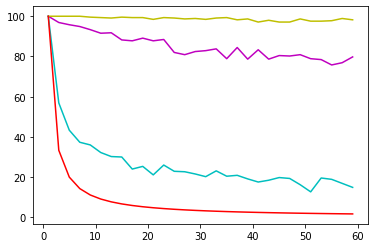

<Figure size 432x288 with 0 Axes>

In [15]:
ways = np.arange(1, 60, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

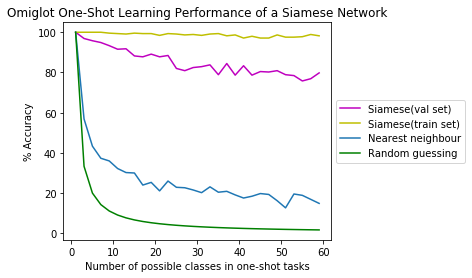

(20, 105, 105, 1)


<Figure size 432x288 with 0 Axes>

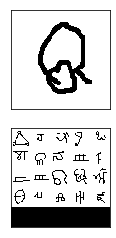

[[1.0126468e-03]
 [4.1599552e-08]
 [4.3495652e-06]
 [6.5492486e-08]
 [1.0518522e-01]
 [2.6278562e-06]
 [2.0475282e-01]
 [1.0246331e-05]
 [4.8750808e-06]
 [1.8874539e-08]
 [7.0743660e-08]
 [4.7930413e-08]
 [9.0708584e-01]
 [5.4187495e-01]
 [5.5213213e-06]
 [1.5336360e-02]
 [9.0366410e-07]
 [8.1315197e-02]
 [2.1670803e-05]
 [1.3392413e-04]]


In [17]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese.predict(inputs)
print(p)



In [ ]:
a=test_nn_accuracy(3,500,loader)
print(a)